In [1]:
import pandas as pd
import numpy as np
import re
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout,Bidirectional, LSTM
from tensorflow.keras.regularizers import l2

2025-06-24 23:52:11.974387: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-24 23:52:11.975939: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-24 23:52:12.005726: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-24 23:52:12.005756: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-24 23:52:12.006552: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          500000    
                                                                 
 global_average_pooling1d (  (None, 100)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 128)               12928     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 513057 (1.96 MB)
Trainable params: 513057 (1.96 MB)
Non-trainable params: 0 (0.00 Byte)
____________________

2025-06-24 23:52:18.360092: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-24 23:52:18.360497: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


10/10 [==============================] - 1s 17ms/step - loss: 0.6686 - accuracy: 0.5656 - val_loss: 0.6519 - val_accuracy: 0.5875
Epoch 2/10
10/10 [==============================] - 0s 6ms/step - loss: 0.6365 - accuracy: 0.6250 - val_loss: 0.6326 - val_accuracy: 0.5750
Epoch 3/10
10/10 [==============================] - 0s 6ms/step - loss: 0.6157 - accuracy: 0.6656 - val_loss: 0.6155 - val_accuracy: 0.6625
Epoch 4/10
10/10 [==============================] - 0s 6ms/step - loss: 0.5826 - accuracy: 0.7531 - val_loss: 0.5980 - val_accuracy: 0.7250
Epoch 5/10
10/10 [==============================] - 0s 6ms/step - loss: 0.5671 - accuracy: 0.7406 - val_loss: 0.5779 - val_accuracy: 0.7250
Epoch 6/10
10/10 [==============================] - 0s 6ms/step - loss: 0.5170 - accuracy: 0.8031 - val_loss: 0.5579 - val_accuracy: 0.7375
Epoch 7/10
10/10 [==============================] - 0s 6ms/step - loss: 0.4694 - accuracy: 0.8562 - val_loss: 0.5372 - val_accuracy: 0.7250
Epoch 8/10
10/10 [============

/home/keen/classifier_project/classifier_env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


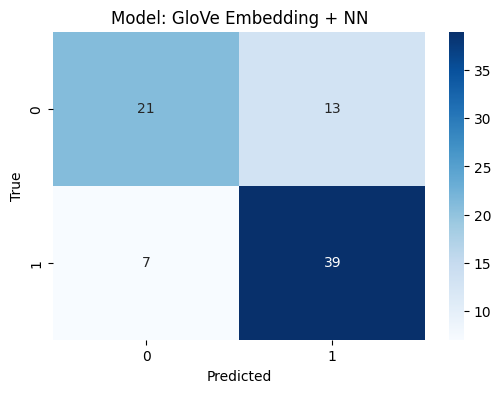

In [2]:
### 1. Load and clean the data ###
def clean_text(text):
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)
    return text

with open('annotated__google.csv', encoding='utf-8', errors='ignore') as f:
    data = pd.read_csv(f)   
data['clean_description'] = data['description'].apply(clean_text)
data = data.dropna(subset=['label', 'clean_description'])

### 2. Tokenization ###
texts = data['clean_description'].tolist()
labels = data['label'].astype(str).tolist()

max_vocab = 5000
max_len = 100

tokenizer = Tokenizer(num_words=max_vocab, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# Save tokenizer
joblib.dump(tokenizer, 'tokenizer.pkl')

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
joblib.dump(label_encoder, 'label_encoder.pkl')

X = np.array(padded)
y = np.array(labels_encoded)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### 3. Load GloVe and create embedding matrix ###
embedding_dim = 100
embedding_index = {}

# Load GloVe embeddings (make sure the path is correct)
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

# Build the embedding matrix
word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_vocab, embedding_dim))
for word, i in word_index.items():
    if i >= max_vocab:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### 4. Build the model using GloVe embeddings ###
model = Sequential([
    Embedding(
        input_dim=max_vocab,
        output_dim=embedding_dim,
        input_length=max_len,
        weights=[embedding_matrix],
        trainable=True  # train GloVe weights?
    ),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

### 5. Train the model ###
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

### 6. Save the model ###
model.save('glove_embedding_model.h5')
print("✅ GloVe model saved as 'glove_embedding_model.h5'")

### 7. Evaluate the model ###
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

print("🔍 GloVe Embedding Classification Report:\n")
print(classification_report(y_test, y_pred))

### 8. Plot confusion matrix ###
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_test, y_pred, title='Model: GloVe Embedding + NN')


In [3]:
oov_count = sum(1 for word, i in tokenizer.word_index.items() if i < max_vocab and word not in embedding_index)
print(f"OOV terms in top {max_vocab}: {oov_count} ({100 * oov_count / max_vocab:.2f}%)")

OOV terms in top 5000: 291 (5.82%)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          500000    
                                                                 
 bidirectional (Bidirection  (None, 128)               84480     
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                      

/home/keen/classifier_project/classifier_env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 0s 10ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82        34
           1       0.87      0.87      0.87        46

    accuracy                           0.85        80
   macro avg       0.85      0.85      0.85        80
weighted avg       0.85      0.85      0.85        80



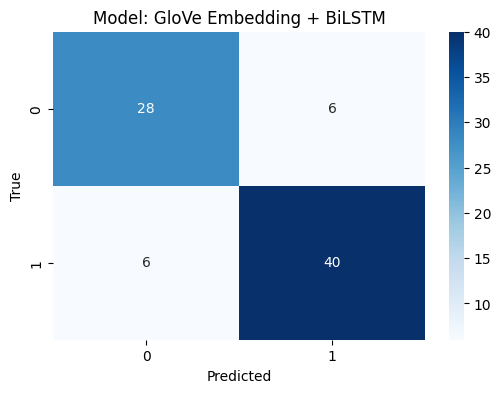

In [4]:
# Using LSTM
# Tokenization and padding
texts = data['clean_description'].tolist()
labels = data['label'].astype(str).tolist()

max_vocab = 5000
max_len = 100

tokenizer = Tokenizer(num_words=max_vocab, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

X = np.array(padded)
y = np.array(labels_encoded)

# Save tokenizer and label encoder for later use
joblib.dump(tokenizer, 'tokenizer.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Load GloVe embeddings
embedding_index = {}
embedding_dim = 100  # or 50/200 depending on your glove file

with open('glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Prepare embedding matrix
embedding_matrix = np.zeros((max_vocab, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_vocab:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Build model with BiLSTM and regularization
model = Sequential([
    Embedding(input_dim=max_vocab, output_dim=embedding_dim, input_length=max_len,
              weights=[embedding_matrix], trainable=False),  # Freeze embeddings
    Bidirectional(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001))),
    Dropout(0.4),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Save the model
model.save('bilstm_glove_model.h5')
print("Model saved as 'bilstm_glove_model.h5'")

# Evaluate model
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

print("Classification Report:\n", classification_report(y_test, y_pred))


plot_confusion_matrix(y_test, y_pred, title='Model: GloVe Embedding + BiLSTM')
